<a href="https://colab.research.google.com/github/kcrig4196/ml-projects/blob/main/DonorPrediction/donation_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Data Handling
import pandas as pd
import numpy as np

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Ignore warnings for cleaner output
import warnings
warnings.filterwarnings("ignore")

# Display all columns in DataFrame
pd.set_option('display.max_columns', None)

print("Libraries imported successfully!")


Libraries imported successfully!


In [2]:
import random

# Set a seed for reproducibility
np.random.seed(42)

# Number of donors
num_donors = 500

# Generate donor IDs
donor_ids = [f"D{str(i).zfill(4)}" for i in range(1, num_donors + 1)]

# Generate donation frequencies (times donated in the past year)
donation_frequencies = np.random.poisson(lam=6, size=num_donors)

# Generate average donation amounts (in USD)
avg_donation_amounts = np.random.normal(loc=50, scale=20, size=num_donors)
avg_donation_amounts = np.clip(avg_donation_amounts, 10, 200)  # Ensure realistic values

# Generate total donation amounts
total_donation_amounts = donation_frequencies * avg_donation_amounts

# Generate recency (days since last donation)
recency = np.random.randint(0, 365, size=num_donors)

# Generate a binary label for future donations (1 = Will donate again, 0 = Won't donate)
will_donate_again = np.where((donation_frequencies > 5) & (recency < 180), 1, 0)

# Create DataFrame
donation_data = pd.DataFrame({
    "Donor_ID": donor_ids,
    "Donation_Frequency": donation_frequencies,
    "Avg_Donation_Amount": avg_donation_amounts.round(2),
    "Total_Donation_Amount": total_donation_amounts.round(2),
    "Recency": recency,
    "Will_Donate_Again": will_donate_again
})

# Display first 5 rows
donation_data.head()


,Donor_ID,Donation_Frequency,Avg_Donation_Amount,Total_Donation_Amount,Recency,Will_Donate_Again
0,D0001,6,89.08,534.50,297,0
1,D0002,6,39.89,239.31,295,0
2,D0003,4,28.82,115.29,224,0
3,D0004,5,79.63,398.17,332,0
4,D0005,4,89.25,357.01,360,0


In [5]:
# Display summary statistics
print("Summary Statistics:\n")
print(donation_data.describe())

# Check for missing values
print("\nMissing Values:\n")
print(donation_data.isnull().sum())

# Check data types
print("\nData Types:\n")
print(donation_data.dtypes)

# Check class distribution (target variable: Will_Donate_Again)
print("\nTarget Variable Distribution:\n")
print(donation_data['Will_Donate_Again'].value_counts(normalize=True) * 100)


Summary Statistics:

       Donation_Frequency  Avg_Donation_Amount  Total_Donation_Amount  \
count          500.000000           500.000000             500.000000   
mean             5.900000            49.264860             292.368660   
std              2.411977            19.775479             175.531774   
min              0.000000            10.000000               0.000000   
25%              4.000000            36.047500             161.405000   
50%              6.000000            48.120000             272.225000   
75%              8.000000            61.935000             387.277500   
max             13.000000           128.520000             968.910000   

          Recency  Will_Donate_Again  
count  500.000000         500.000000  
mean   181.248000           0.268000  
std    106.742637           0.443361  
min      0.000000           0.000000  
25%     91.750000           0.000000  
50%    184.000000           0.000000  
75%    272.250000           1.000000  
max    36

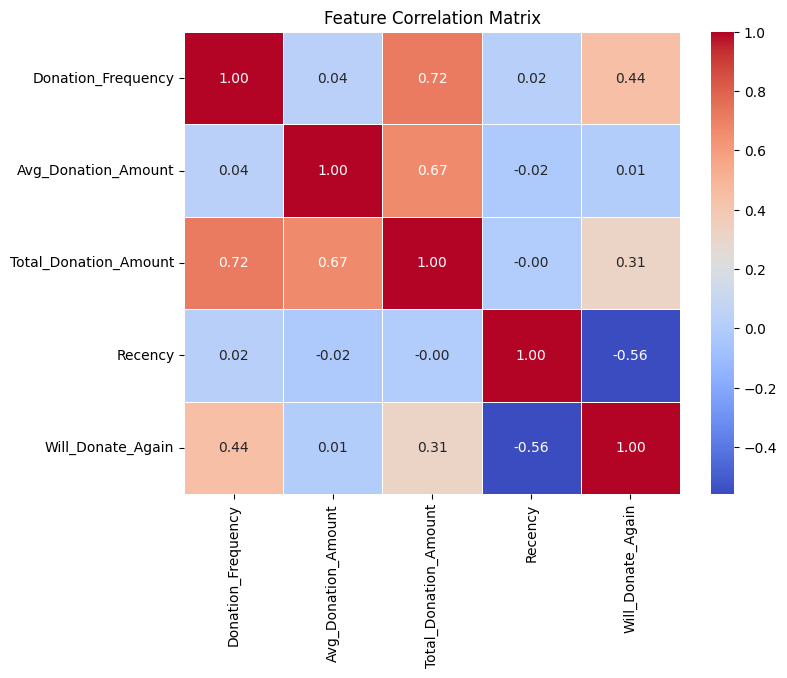

In [6]:
# Compute correlation matrix
correlation_matrix = donation_data.drop(columns=["Donor_ID"]).corr()

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Matrix")
plt.show()


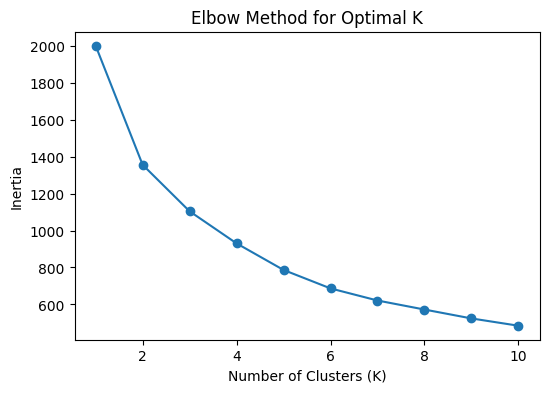

In [7]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Select features for clustering
clustering_features = donation_data[['Donation_Frequency', 'Avg_Donation_Amount', 'Total_Donation_Amount', 'Recency']]

# Standardize features (important for K-Means)
scaler = StandardScaler()
scaled_features = scaler.fit_transform(clustering_features)

# Determine optimal clusters using Elbow Method
inertia = []
k_range = range(1, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(scaled_features)
    inertia.append(kmeans.inertia_)

# Plot the Elbow Curve
plt.figure(figsize=(6, 4))
plt.plot(k_range, inertia, marker="o")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Inertia")
plt.title("Elbow Method for Optimal K")
plt.show()


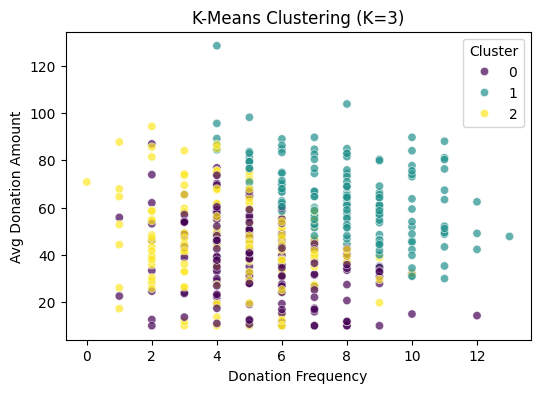

In [8]:
# Apply K-Means clustering with the chosen K
optimal_k = 3  # Change this if needed based on elbow curve
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
donation_data["Cluster"] = kmeans.fit_predict(scaled_features)

# Visualize clusters (scatter plot for 2 features)
plt.figure(figsize=(6, 4))
sns.scatterplot(x=donation_data["Donation_Frequency"], y=donation_data["Avg_Donation_Amount"],
                hue=donation_data["Cluster"], palette="viridis", alpha=0.7)
plt.xlabel("Donation Frequency")
plt.ylabel("Avg Donation Amount")
plt.title(f"K-Means Clustering (K={optimal_k})")
plt.show()


In [9]:
# Define the target variable: Will the donor donate again?
donation_data["Will_Donate_Again"] = (donation_data["Recency"] <= 3).astype(int)

# Check class distribution
donation_data["Will_Donate_Again"].value_counts()


,count
Will_Donate_Again,
0,496
1,4


In [10]:
from sklearn.model_selection import train_test_split

# Select relevant features
X = donation_data[["Donation_Frequency", "Avg_Donation_Amount", "Total_Donation_Amount", "Recency", "Cluster"]]
y = donation_data["Will_Donate_Again"]

# Split data into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [11]:
from sklearn.ensemble import RandomForestClassifier

# Initialize and train the classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Make predictions
y_pred = clf.predict(X_test)


In [12]:
from sklearn.metrics import accuracy_score, classification_report

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.2f}")

# Display classification report
print(classification_report(y_test, y_pred))


Model Accuracy: 1.00
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        99
           1       1.00      1.00      1.00         1

    accuracy                           1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100



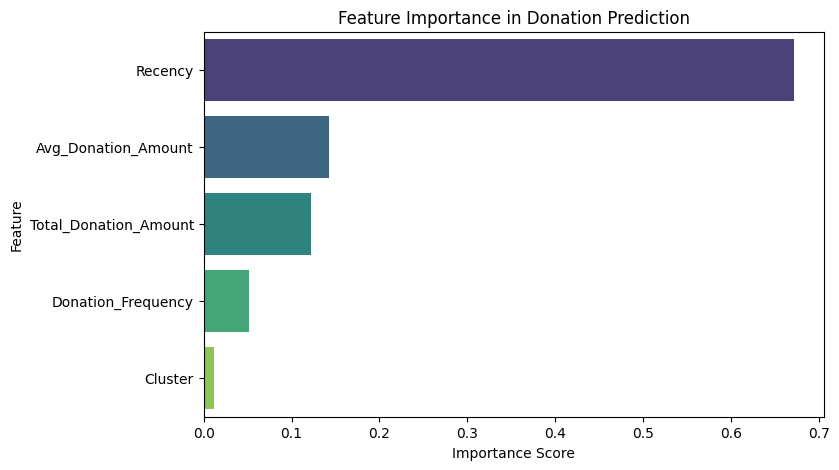

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Get feature importance
feature_importance = clf.feature_importances_

# Create a DataFrame for visualization
features = X.columns
importance_df = pd.DataFrame({"Feature": features, "Importance": feature_importance})

# Sort by importance
importance_df = importance_df.sort_values(by="Importance", ascending=False)

# Plot feature importance
plt.figure(figsize=(8,5))
sns.barplot(x="Importance", y="Feature", data=importance_df, palette="viridis")
plt.title("Feature Importance in Donation Prediction")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.show()
